In [1]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

In [2]:
path = 'lnr.txt'
text = open(path, encoding="utf-8").read().lower() + open("novelas.txt", encoding="utf-8").read().lower()
print('corpus length:', len(text))

corpus length: 423923


In [3]:
tokenizer = RegexpTokenizer(r'\b\w+\b')
words = tokenizer.tokenize(text)

In [4]:
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [5]:
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['biblioteca', 'de', 'la', 'nación', 'h']
conscience


In [6]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

In [7]:
print(X[0][0])

[False False False ... False False False]


In [8]:
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

In [9]:
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=50, shuffle=True).history

Epoch 1/50
530/530 [==============================] - 341s 477ms/step - loss: 7.0051 - accuracy: 0.0546 - val_loss: 6.9146 - val_accuracy: 0.0757
Epoch 2/50
530/530 [==============================] - 245s 463ms/step - loss: 6.1223 - accuracy: 0.1134 - val_loss: 7.1126 - val_accuracy: 0.0830
Epoch 3/50
530/530 [==============================] - 252s 476ms/step - loss: 5.9631 - accuracy: 0.1518 - val_loss: 7.5718 - val_accuracy: 0.0863
Epoch 4/50
530/530 [==============================] - 245s 462ms/step - loss: 5.8661 - accuracy: 0.1984 - val_loss: 8.0426 - val_accuracy: 0.0883
Epoch 5/50
530/530 [==============================] - 248s 469ms/step - loss: 5.4935 - accuracy: 0.2594 - val_loss: 8.2500 - val_accuracy: 0.0746
Epoch 6/50
530/530 [==============================] - 223s 421ms/step - loss: 5.0163 - accuracy: 0.3295 - val_loss: 8.3617 - val_accuracy: 0.0709
Epoch 7/50
530/530 [==============================] - 226s 426ms/step - loss: 4.7152 - accuracy: 0.3824 - val_loss: 8.4420 -

In [10]:
#unique_words = np.unique(words)
#unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

model.save('keras_next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('keras_next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

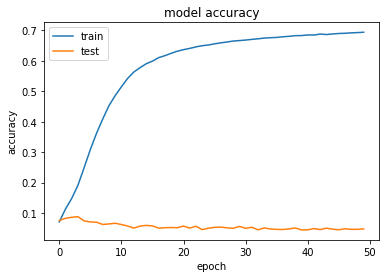

In [11]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

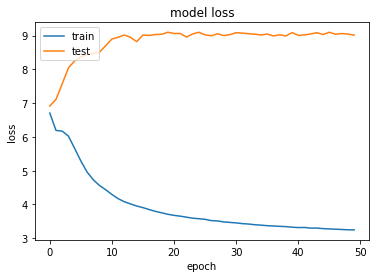

In [12]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [13]:
def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        print(word)
        x[0, t, unique_word_index[word]] = 1
    return x

In [14]:
prepare_input("la niña era")

la
niña
era


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [15]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [16]:
def predict_completions(text, n=3):
    if text == "":
        return("0")
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [unique_words[idx] for idx in next_indices]

In [27]:
q = "en mi mano para usted"
print("correct sentence: ",q)
seq = " ".join(tokenizer.tokenize(q.lower())[0:5])
print("Sequence: ",seq)
print("next possible words: ", predict_completions(seq, 5))

correct sentence:  en mi mano para usted
Sequence:  en mi mano para usted
en
mi
mano
para
usted
next possible words:  ['le', 'esta', 'un', 'hablar', 'la']
